# April 16, 2025: motivating figure
compare solutions of all models, and their multiplicities

In [1]:
import os
import graph_tool.all as gt
import numpy as np
import pandas as pd

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)


args.dc, args.sbm = True, 'd'
args.nested = True if args.sbm in ['h'] else False

args.wait = 120 #6000
args.force_niter = 5000
args.num_draws = int((1/2) * args.force_niter)
args.niter = 10

args.B = 25
args.gamma = 1.0 #2.0

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-dc-d'

In [3]:
out_dir = f'dummy-network-and-model-fits'
os.system(f'mkdir -p {out_dir}')

0

In [4]:
# g = gt.collection.data['polbooks']
g = gt.collection.data['polbooks']
g

<Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e120>

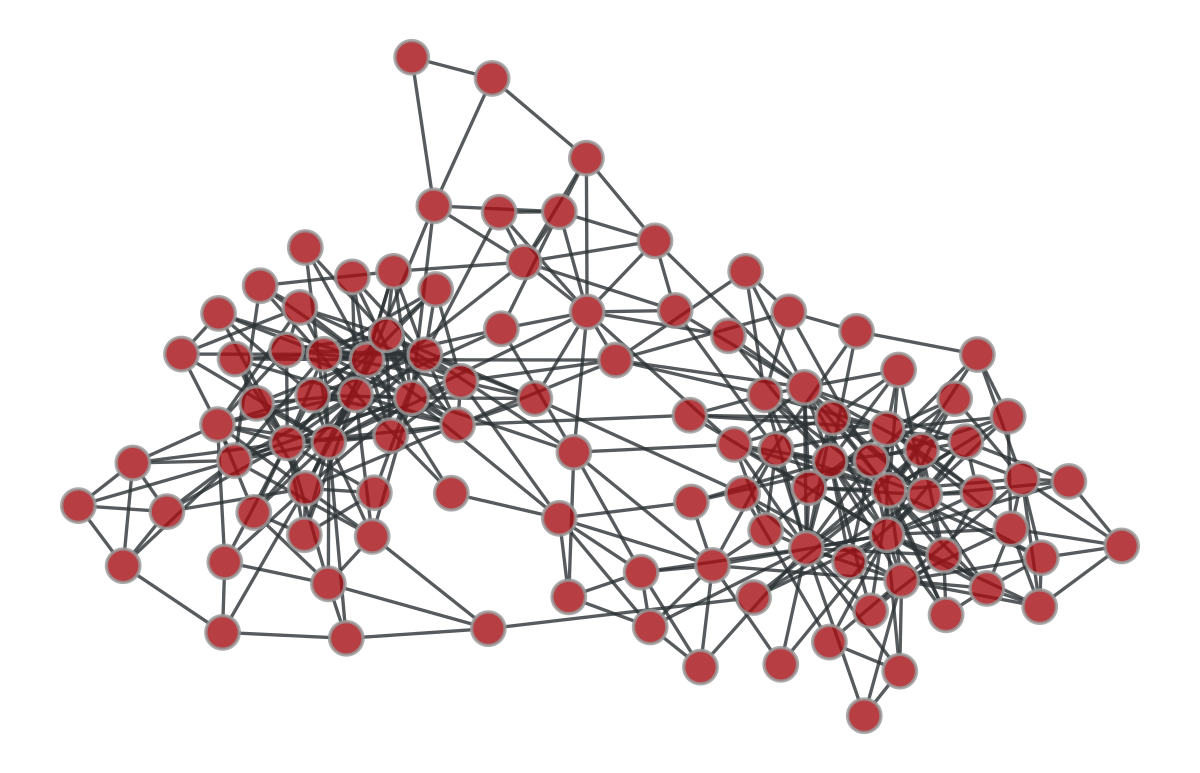

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f229245e120, at 0x7f235fe815b0>

In [5]:
gt.graph_draw(g, pos=g.vp['pos'])

In [6]:
gt.graph_draw(g, pos=g.vp['pos'], output=f'./{out_dir}/graph.svg')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f229245e120, at 0x7f2292286cf0>

In [7]:
def create_state(args, ):
    state_df = pd.DataFrame(columns=['a', 'd', 'o', 'h', 'm'],)
    state_df.loc['state'] = [
        gt.PPBlockState, gt.BlockState, 
        gt.OverlapBlockState, gt.NestedBlockState,
        gt.ModularityState,
    ]
    state_df.loc['state_args'] = [
        dict(), dict(deg_corr=args.dc, B=args.B), 
        dict(deg_corr=args.dc, B=args.B), dict(deg_corr=args.dc, B=args.B),
        dict(entropy_args=dict(gamma=args.gamma)),
    ]
    state, state_args = state_df[args.sbm]
    return state, state_args

In [8]:
def heuristic_state(args, g, state, state_args):
    if not args.sbm in ['h']:
        state = gt.minimize_blockmodel_dl(g, state=state, state_args=state_args)
    else:
        state = gt.minimize_nested_blockmodel_dl(g, state=state, state_args=state_args)
    return state

In [9]:
def mcmc_eq(args, g, state):
    bs = [] # partitions
    dls = []
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        dls.append(s.entropy())

    gt.mcmc_equilibrate(
        state,
        wait=args.wait,
        force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, dls

def nested_mcmc_eq(args, g, state):
    bs = []
    def collect_partitions(s):
        bs.append(s.get_bs())
        
    gt.mcmc_equilibrate(
        state, 
        wait=args.wait, 
        force_niter=args.force_niter, 
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs,

In [10]:
def posterior_modes(args, bs):
    mode = gt.PartitionModeState(bs, relabel=True, nested=args.nested, converge=True)
    if args.sbm in ['h']:
        bs = list(mode.get_nested_partitions().values())
    else:
        bs = list(mode.get_partitions().values())

    cmode = gt.ModeClusterState(bs, relabel=False, nested=args.nested)
    gt.mcmc_equilibrate(cmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))

    cmode.relabel(maxiter=1000)

    return cmode

In [11]:
state, state_args = create_state(args)
state, state_args

(graph_tool.inference.blockmodel.BlockState, {'deg_corr': True, 'B': 25})

In [12]:
state = heuristic_state(args, g, state, state_args)
state

<BlockState object with 105 blocks (4 nonempty), degree-corrected, for graph <Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e120>, at 0x7f229245fa10>

In [13]:
if not args.sbm in ['h']:
    state, bs, dls = mcmc_eq(args, g, state)
else:
    state, bs = nested_mcmc_eq(args, g, state)
state

<BlockState object with 105 blocks (4 nonempty), degree-corrected, for graph <Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e120>, at 0x7f229245fa10>

In [14]:
len(bs)

4999

In [15]:
pmode = posterior_modes(args, bs)
pmode

In [16]:
pmode.get_modes()

In [17]:
# modes = pmode.get_modes()
# for i, mode in enumerate(modes):
#     b = mode.get_max_nested()
#     b = b[0] if not args.sbm in ['h'] else b
#     pv = mode.get_marginal(state.g)

#     print(f'mode {i} with size {mode.get_M()/len(bs):.3f}')
#     state = state.copy(b=b) if not args.sbm in ['h'] else state.copy(bs=b)
#     state.draw(
#         vertex_shape='pie', 
#         vertex_pie_fractions=pv, 
#         pos=g.vp['pos'],
#     )

In [18]:
modes = pmode.get_modes()
for i, mode in enumerate(modes):
    b = mode.get_max_nested()
    b = b[0] if not args.sbm in ['h'] else b
    
    print(f'mode {i} with size {mode.get_M()/len(bs):.3f}')

    if not args.sbm in ['o']:
        state = state.copy(b=b) if not args.sbm in ['h'] else state.copy(bs=b)
        # pv = mode.get_marginal(g)
        print(state)
        state.draw(
            # vertex_shape='pie', 
            # vertex_pie_fractions=pv, 
            pos=g.vp['pos'],
            output=f'./{out_dir}/{SBM}_mode-{i:02d}.svg',
        )
        state.draw(
            # vertex_shape='pie', 
            # vertex_pie_fractions=pv, 
            pos=g.vp['pos'],
            edge_pen_width=0, # disable edge drawing
            output=f'./{out_dir}/{SBM}_mode-{i:02d}_nodes.svg',
        )
    else:
        state = state.copy(b=b)
        print(state)
        state.draw(
            vertex_shape='pie', 
            # vertex_pie_fractions=pv, 
            pos=g.vp['pos'],
            output=f'./{out_dir}/{SBM}_mode-{i:02d}.svg',
        )

mode 0 with size 0.325
<BlockState object with 4 blocks (4 nonempty), degree-corrected, for graph <Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e120>, at 0x7f22922b9450>
mode 1 with size 0.226
<BlockState object with 5 blocks (4 nonempty), degree-corrected, for graph <Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e120>, at 0x7f22922b96d0>
mode 2 with size 0.166
<BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e120>, at 0x7f22922b9810>
mode 3 with size 0.105
<BlockState object with 5 blocks (5 nonempty), degree-corrected, for graph <Graph object, undirected, with 105 vertices and 441 edges, 3 internal vertex properties, 2 internal graph properties, at 0x7f229245e1